# NT 12-Month Forecast and Historic Usage Visualization for "College X"
NT is an online, on-demand tutoring 24/7/365 across a range of academic subjects. College X is a 2-year college located in Central California. The purpose of this analysis is to provide a forecast for usage for the year 2021. Also included here is an exploratory analysis of historical usage trends beginning Jan 2017 through Dec 2020. The predictive analytic used here is the decomposable time-series, generalized additive model (GAM), named [Facebook Prophet](https://facebook.github.io/prophet/).

## Import Libraries - Prepare Data

In [449]:
import warnings; 
warnings.simplefilter('ignore')

In [450]:
#import out libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import random
import statsmodels.api as sm
# prophet by Facebook
from fbprophet import Prophet
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [451]:
#read in data
df = pd.read_csv('SacCityTimeSeries.csv')

In [452]:
#check column names
df.columns

Index(['Group', 'Start', 'Time (minutes)'], dtype='object')

In [453]:
#drop Group column
df.drop(['Group'], axis =1, inplace = True)

In [454]:
#rename columns to fit Prophet model
df.columns = ['ds', 'y']

In [455]:
df.head()

,ds,y
0,6/17/19 11:43,122
1,3/19/20 18:18,114
2,3/30/18 19:10,98
3,5/14/18 20:19,98
4,10/15/20 18:02,96


In [456]:
#cast ds as date/time
df['ds'] = pd.DatetimeIndex(df['ds'])

In [457]:
#check datatpes for columns
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [458]:
#check head
df.head()

,ds,y
0,2019-06-17 11:43:00,122
1,2020-03-19 18:18:00,114
2,2018-03-30 19:10:00,98
3,2018-05-14 20:19:00,98
4,2020-10-15 18:02:00,96


## Plot Historical Data

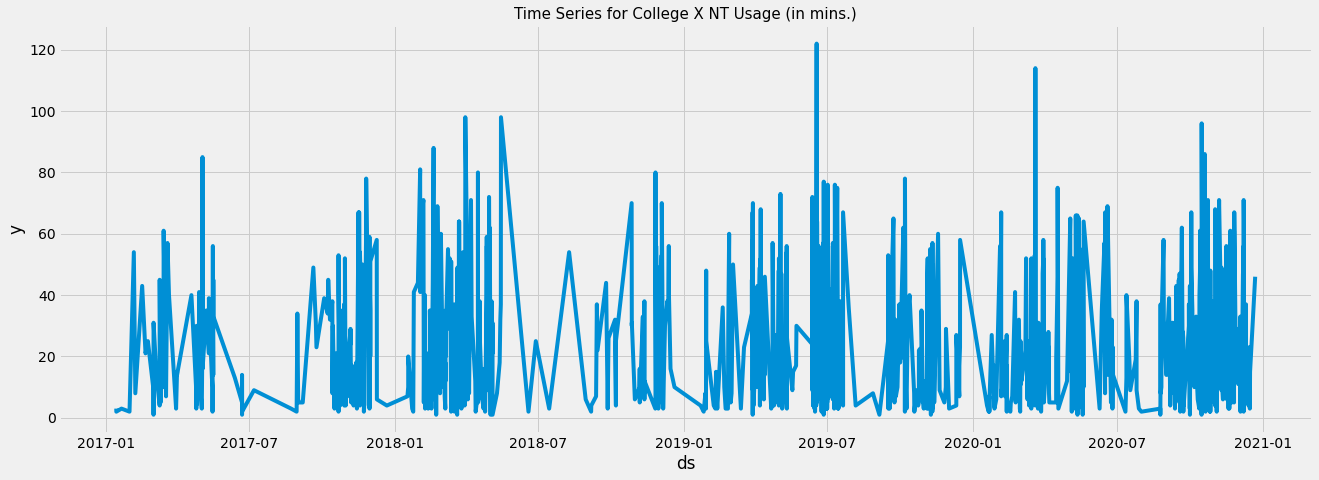

In [459]:
#Plot and review our historical data
fig, ax = plt.subplots(figsize=(20,7))
a = sns.lineplot(x="ds", y="y", data=df)
a.set_title("Time Series for College X NT Usage (in mins.)",fontsize=15)
plt.show()

In [460]:
#Exploratory Data Analysis of time series individual elements
#creating new dataframe with new series features
def date_features(df, label=None):
    df = df.copy()
    df['date'] = df.ds
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime('%A')
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth', 'hour', 'weekofyear']]
   
    if label:
        y = df[label]
        return X, y
    return X
X, y = date_features(df, label='y')
df_new = pd.concat([X, y], axis=1)
df_new = df_new.sort_values(by=['year'], axis =0, ascending=True)
df_new.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,hour,weekofyear,y
306,Wednesday,3,August,2017,242,30,16,35,34
246,Tuesday,4,October,2017,276,3,13,40,39
245,Wednesday,2,May,2017,130,10,23,19,39
1046,Friday,1,March,2017,69,10,23,10,5
1047,Wednesday,2,June,2017,172,21,19,25,5


## Monthly Total Usage by Year (2017-2020)

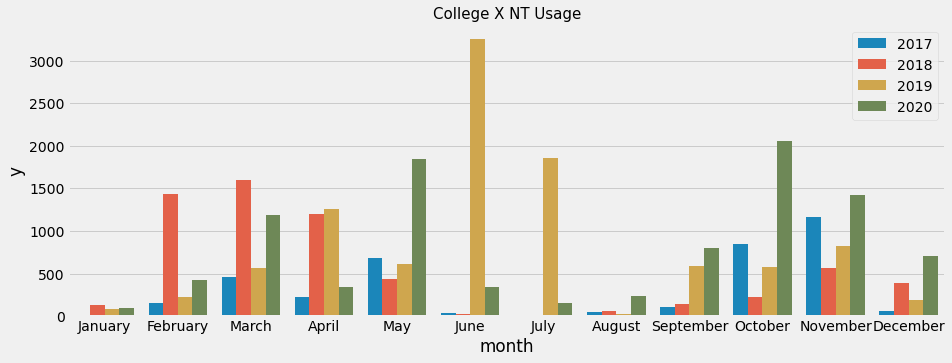

In [464]:
#Plotting new time series created above to analyze seasonality. 
fig, ax = plt.subplots(figsize=(14,5))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(data=df_new, x="month", y="y",hue = 'year', estimator = sum, ci=None, order=['January', 'February', 'March', 'April'
, 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
a.set_title("College X NT Usage",fontsize=15)
plt.legend(loc='upper right')
plt.show()

## Total Usage by month, year, day of week, quarter

Text(0.5, 1.0, 'Total College X NT Usage by year')

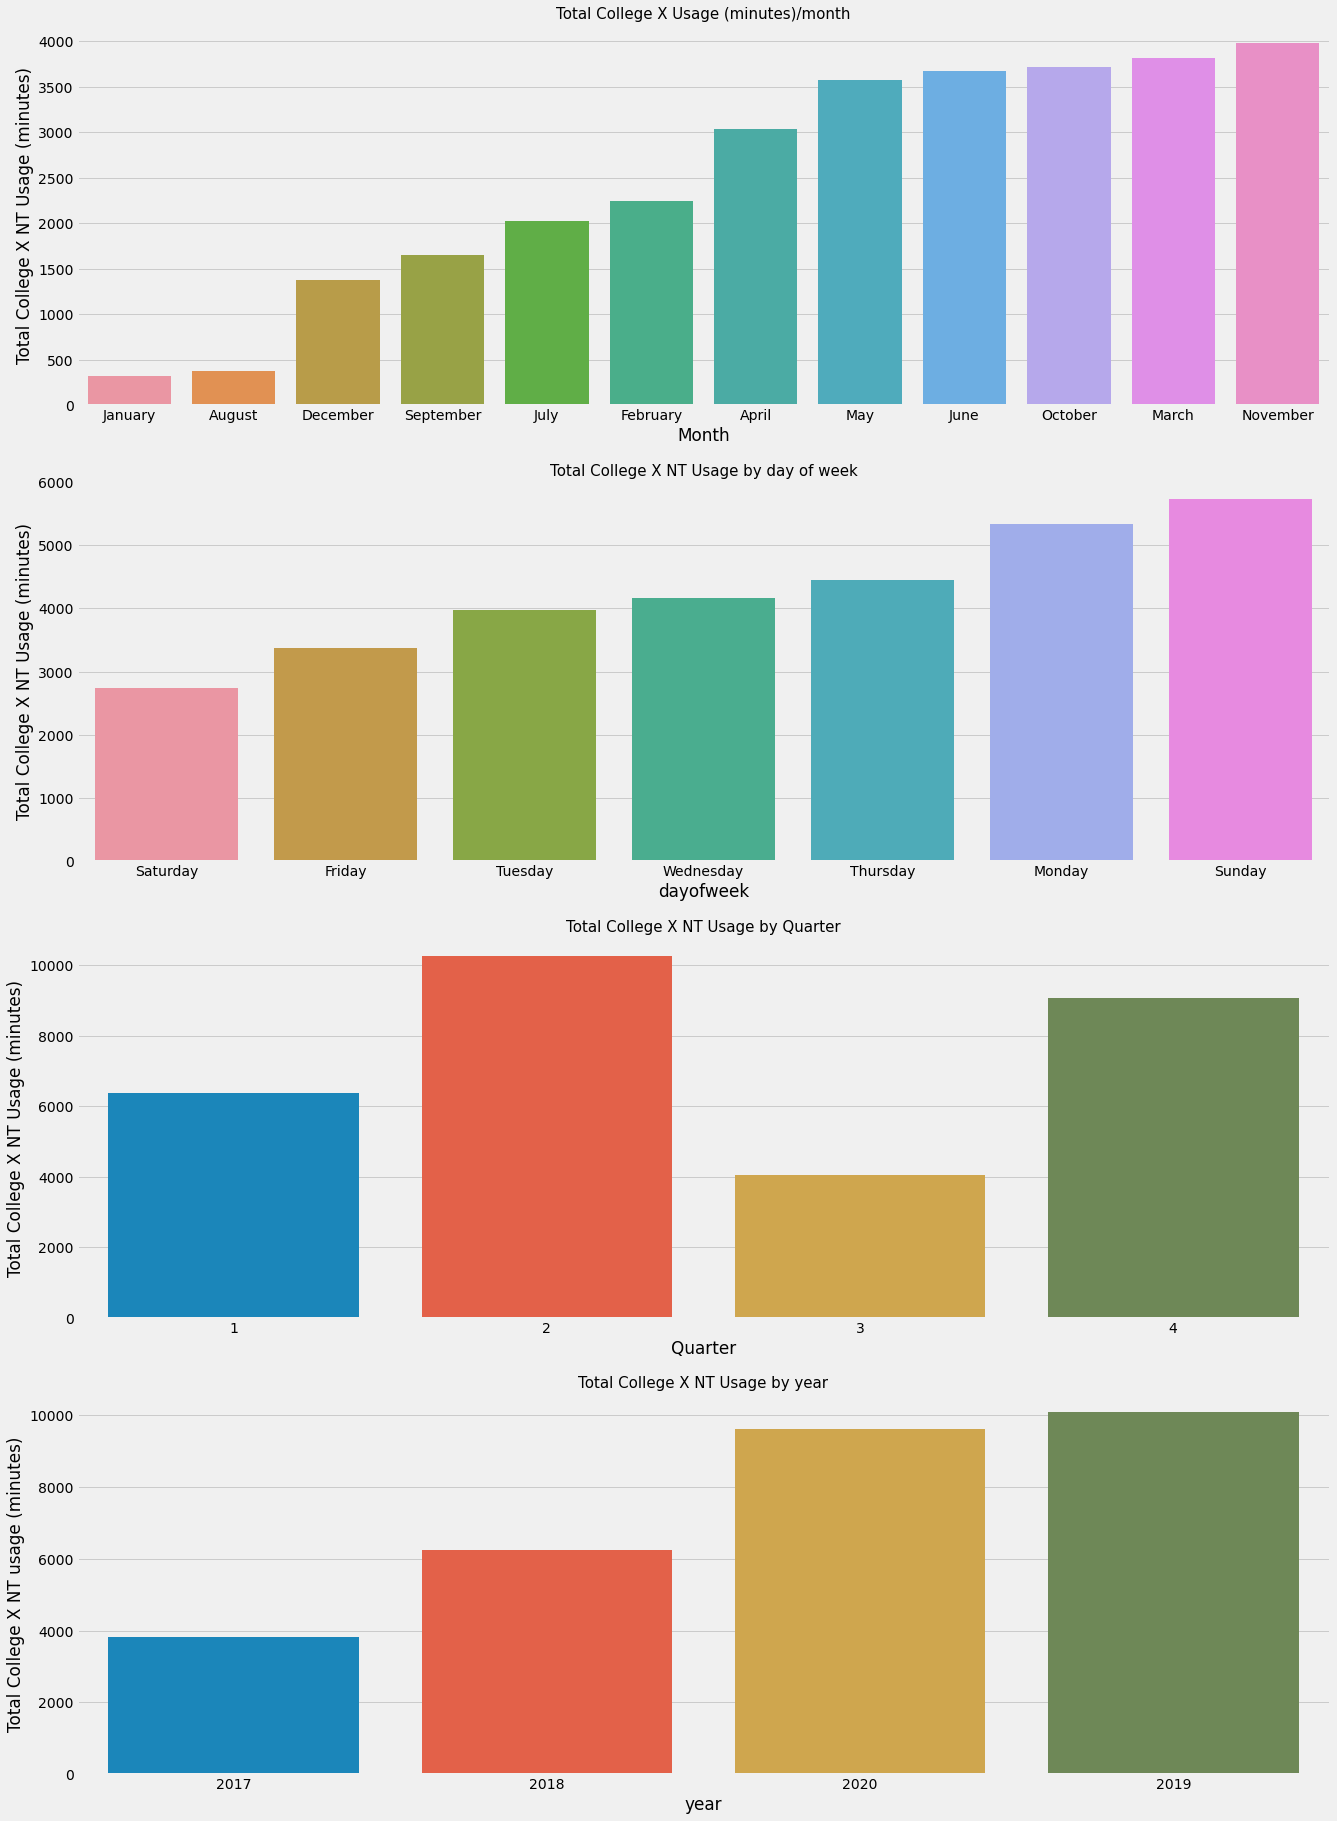

In [428]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(20,30)

monthAggregated = pd.DataFrame(df_new.groupby("month")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthAggregated,x="month",y="y",ax=ax1)
ax1.set(xlabel='Month', ylabel='Total College X NT Usage (minutes)')
ax1.set_title("Total College X Usage (minutes)/month",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthAggregated,x="dayofweek",y="y",ax=ax2)
ax2.set(xlabel='dayofweek', ylabel='Total College X NT Usage (minutes)')
ax2.set_title("Total College X NT Usage by day of week",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("quarter")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthAggregated,x="quarter",y="y",ax=ax3)
ax3.set(xlabel='Quarter', ylabel='Total College X NT Usage (minutes)')
ax3.set_title("Total College X NT Usage by Quarter",fontsize=15)

monthAggregated = pd.DataFrame(df_new.groupby("year")["y"].sum()).reset_index().sort_values('y')
sns.barplot(data=monthAggregated,x="year",y="y",ax=ax4)
ax4.set(xlabel='year', ylabel='Total College X NT usage (minutes)')
ax4.set_title("Total College X NT Usage by year",fontsize=15)

## Create the Forecasting Model

In [409]:
#Declaring Holidays
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2018-01-01', '2019-01-01', '2020-01-01',
                        '2021-01-01', '2012-01-01', '2017-12-25',
                        '2018-12-25', '2019-12-25', '2020-12-25',
                        '2021-12-25', '2022-12-25',]),
  'lower_window': 0,
  'upper_window': 0,
})

In [410]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,holiday,2018-01-01,0,0
1,holiday,2019-01-01,0,0
2,holiday,2020-01-01,0,0
3,holiday,2021-01-01,0,0
4,holiday,2012-01-01,0,0


In [411]:
m = Prophet(holidays=holidays, yearly_seasonality=10)
m.fit(df)

In [422]:
future = m.make_future_dataframe(freq = 'D', periods=380)
future.tail()

,ds
1658,2022-01-02 08:09:00
1659,2022-01-03 08:09:00
1660,2022-01-04 08:09:00
1661,2022-01-05 08:09:00
1662,2022-01-06 08:09:00


In [423]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
1651,2021-12-26 08:09:00,15.374156,-9.639254,38.886243
1652,2021-12-27 08:09:00,11.798761,-14.043584,38.464308
1653,2021-12-28 08:09:00,11.366216,-13.147129,34.413453
1654,2021-12-29 08:09:00,8.716159,-13.422928,33.715832
1655,2021-12-30 08:09:00,8.162234,-16.228293,30.807797
1656,2021-12-31 08:09:00,9.953868,-14.295639,35.469016
1657,2022-01-01 08:09:00,5.891460,-20.119730,31.435546
1658,2022-01-02 08:09:00,7.663311,-15.719001,31.092433
1659,2022-01-03 08:09:00,4.454813,-20.186461,28.398645
1660,2022-01-04 08:09:00,4.489812,-21.183535,30.360939


# 2021 Usage Forecast

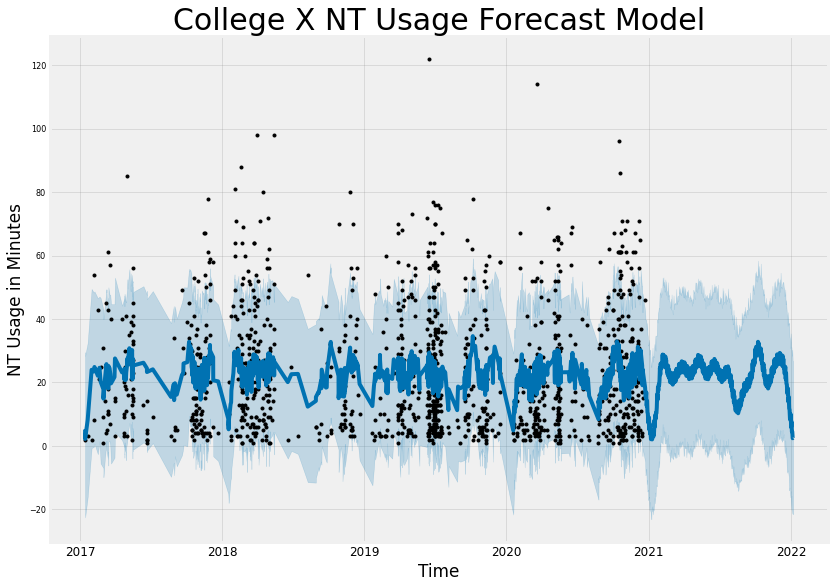

In [429]:
fig1 = m.plot(forecast, xlabel='Time', ylabel='NT Usage in Minutes', figsize=(12, 8))
ax = fig1.gca()
ax.set_title("College X NT Usage Forecast Model", size=30)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=8)
plt.savefig("SCCTimeSeriesProphet.png")
#code to add and visualize changepoints
#from fbprophet.plot import add_changepoints_to_plot
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)

## Usage Trend Visualizations

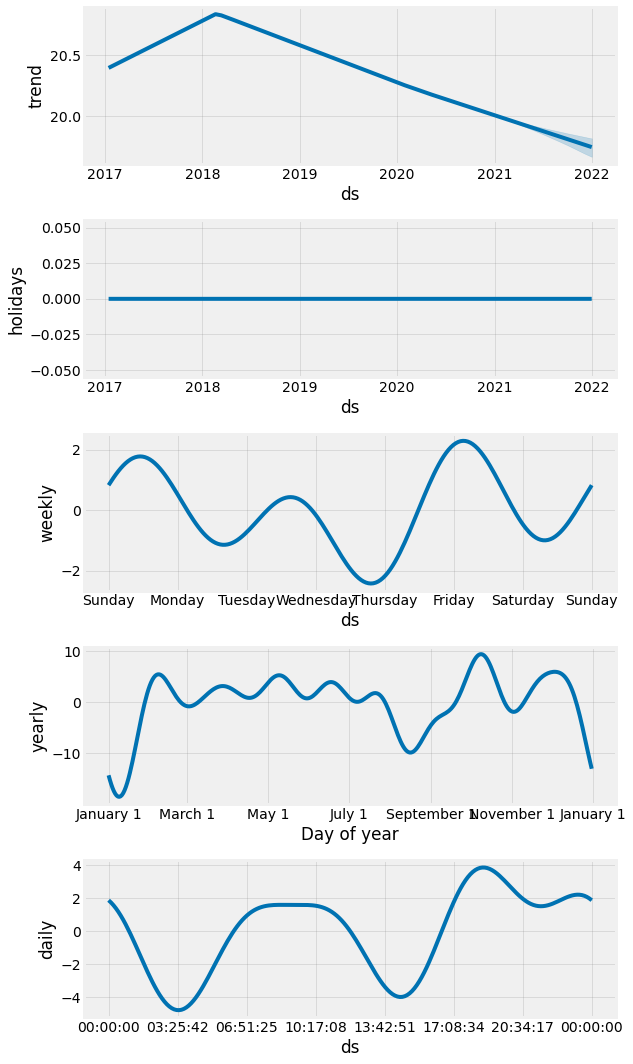

In [415]:
fig2 = m.plot_components(forecast)